In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import metrics
import xgboost as xgb

## Импорт данных

In [2]:
data = pd.read_csv('/content/drive/MyDrive/sasha_test/regression.csv')
data.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


## Анализ целевой переменной

Построим распределение *target_sum*

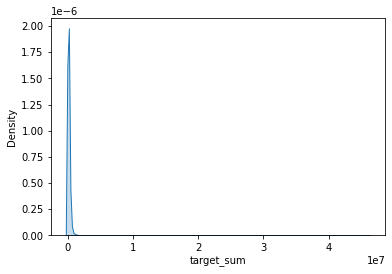

In [3]:
snsplot = sns.kdeplot(data['target_sum'], shade=True, )
fig = snsplot.get_figure()
fig.set_size_inches(6, 4)

Слишком большие значения переменной, прологарифмируем переменную.

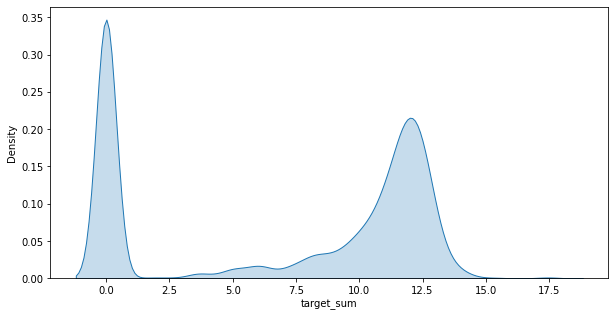

In [4]:
snsplot = sns.kdeplot(np.log(data['target_sum']+1), shade=True)
fig = snsplot.get_figure()
fig.set_size_inches(10, 5)

Наблюдается бимодальное распределение. Проанализируем связь переменных *target_flag* и *target_sum*.

Построим распределение для семплов с *target_flag* == 0 

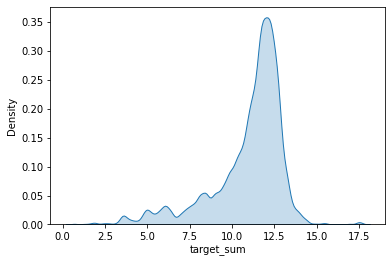

In [5]:
snsplot = sns.kdeplot(np.log(data['target_sum'][data['target_flag'] == 1]+1), shade=True)
fig = snsplot.get_figure()
fig.set_size_inches(6, 4)

Левая мода около значения ноль полностью отсеклась.

* Сумма по переменной *target_sum* для семплов *target_flag*==0  равна нулю.

* При этом значение '0' переменной *target_flag* однозначно определяет нулевое значение для *target_sum*

In [6]:
print(sum(data['target_sum'][data['target_flag'] == 0]))
print(sum(data['target_flag'][data['target_sum'] == 0]))

0.0
0


## Анализ признаков

Подсчитаем средние значения *target_sum* по категориям дискретных признаков.

In [ ]:
data[data['target_flag'] != 0].groupby("PERIOD").apply(lambda x: x.mean())

,cl_id,MCC,currency,amount,target_flag,target_sum
PERIOD,,,,,,
01/01/2017,5663.975764,5705.032453,810.209868,7606.277028,1.0,2.668997e+05
01/01/2018,3164.356138,5775.755668,815.723221,5242.633628,1.0,2.524755e+05
01/02/2017,5067.149793,5700.491175,811.034387,5472.190737,1.0,1.414485e+05
01/02/2018,2916.272863,5795.509940,807.187873,4052.072783,1.0,1.765858e+05
01/03/2017,4129.059406,5703.420921,809.222772,5582.500317,1.0,2.347547e+05
01/03/2018,2574.833550,5783.244473,825.042913,3416.561801,1.0,2.130618e+05
01/04/2017,3623.795311,5692.939319,808.428577,5371.478911,1.0,2.664282e+05
01/04/2018,2199.629630,5844.111111,816.481481,6393.868889,1.0,2.098063e+05
01/05/2017,3302.049566,5710.840724,811.030318,4999.241619,1.0,2.555838e+05


Средние значения целевой переменной по периодам имеют схожие значения, но встречаются месяцы в которых средняя *target_sum* заметно отличается от среднего по датасету, например 11/2016.

In [ ]:
data['channel_type'] = data['channel_type'].fillna('unknown')
data[data['target_flag'] != 0].groupby("channel_type").apply(lambda x: x.mean())

,cl_id,MCC,currency,amount,target_flag,target_sum
channel_type,,,,,,
type1,6344.099962,5705.559244,809.699514,6033.858149,1.0,147091.145828
type2,1728.767644,5705.900789,810.622791,5029.345316,1.0,357399.511522
type3,3348.452939,5734.524525,810.851083,4992.434017,1.0,118166.823168
type4,216.063768,5721.974203,811.986957,7560.944087,1.0,227130.042174
type5,102.122496,5708.771356,812.359429,5173.730465,1.0,103131.339807
unknown,28.590803,5700.192518,810.955573,4074.856500,1.0,193280.915246


Средние значения заметно различаются по каждому из каналов, признак важен.

In [ ]:
data[data['target_flag'] != 0].groupby("trx_category").apply(lambda x: x.mean())

,cl_id,MCC,currency,amount,target_flag,target_sum
trx_category,,,,,,
BACK_TRX,4335.154040,5516.674874,812.164773,8625.682241,1.0,315305.794110
C2C_IN,4217.832282,5299.117781,809.747289,14200.323168,1.0,150936.347675
C2C_OUT,3519.407084,5587.473842,810.000000,15571.884063,1.0,252781.401736
CASH_ADV,3668.555556,6010.000000,789.777778,21558.987778,1.0,148470.229444
CAT,2841.872910,5037.341137,810.000000,18718.962564,1.0,174063.315396
DEPOSIT,5366.851111,6012.244444,810.009091,27962.587637,1.0,135170.538065
POS,3931.305934,5675.578065,810.339022,2603.009868,1.0,255293.843255
WD_ATM_OTHER,2583.876747,6011.000000,805.103156,10725.748125,1.0,289490.021897
WD_ATM_PARTNER,3374.582946,6011.000000,810.087949,23741.571529,1.0,182328.310351


Средние значения *target_sum* различны для каждой из категорий *trx_category*, следовательно данный признак может стать репрезентативным для модели-регрессора.

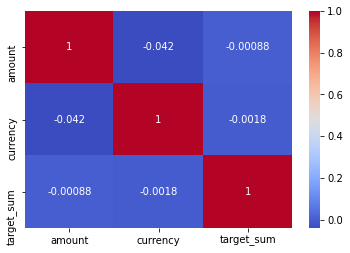

In [ ]:
representative = ['amount', 'currency', 'target_sum'] 
corr = data[representative][data['target_flag'] != 0].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

Корреляция между количественными переменными отсутствует.

## Подготовка данных

На основании анализа переменных были выбраны следующие категориальные и непрерывные переменные.

In [7]:
data['channel_type'] = data['channel_type'].fillna('unknown')
cat_features =['PERIOD', 'channel_type', 'trx_category']
cont_features = ['amount' , 'currency']
flag_feature = ['target_flag']

При проведении экспериментов, обнаружилось, что регрессор корректно использует переменную *target_flag* и предсказывает *target_sum*=0, если значение флага нулевое. 

In [8]:
def one_hot_transform(train, cat_features):
  """
  Function for one-hot encoding of discrete variable
  """
  final_columns = []

  for feature in cat_features:
    for category in np.unique(np.array(train[feature])):
      train[category] = np.array([0]*len(train))
      final_columns.append(category)

    for i in range(len(train)):
      train[train[feature][i]][i] = 1
  
  return train[final_columns]

In [9]:
train_one_hot = one_hot_transform(data.copy(), cat_features)
features = pd.concat((train_one_hot, data[cont_features], data[flag_feature]), axis=1)

## Обучение регрессора

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, data['target_sum'], 
                                                    test_size = 0.2, random_state=42)

#### base RFRegressor

In [ ]:
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mae = metrics.mean_absolute_error(y_pred, y_test)
print("MAE: ", round(mae, 1))

MAE:  196864.7


#### RandomSearch параметров для регрессора

In [ ]:
regressor = RandomForestRegressor(random_state = 42)

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]
max_depth = [60]
max_depth.append(None)
min_samples_split = [2, 6]
min_samples_leaf = [2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

rf_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid, 
                              random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(X_train, y_train)
rf_random.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

#### Обучение регрессора с найденными параметрами

In [ ]:
regressor = RandomForestRegressor(random_state = 42, max_depth = None,
                                  max_features = 'sqrt', min_samples_leaf = 4, 
                                  min_samples_split = 2, n_estimators = 100)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mae = metrics.mean_absolute_error(y_pred, y_test)
print("MAE: ", round(mae, 1))

MAE:  181776.0


#### Обучение регрессора на прологарифмированный таргет

* После предсказания производим операцию обратную логарифмированию. 

* Для семплов, в которых *target_flag* = 0, зануляем *target_sum*.

In [ ]:
regressor.fit(X_train, np.log(y_train+1))
y_pred = regressor.predict(X_test)

pred = np.exp(y_pred)-1
pred[X_test['target_flag'] == 0] = 0

mae = metrics.mean_absolute_error(pred, y_test)
print("MAE: ", round(mae, 1))

MAE:  138169.5


Исходя из распределения для прологарифмированной *target_sum* (см. ячейку 5), оставим для обучения только те семплы, *log(target_sum)* которых находится в интервале значений от 7.5 до 15

In [ ]:
idxs = (np.log(y_train+1)>=7.5) * (np.log(y_train+1)<=15) 

regressor.fit(X_train[idxs], np.log(y_train[idxs]+1))
y_pred = regressor.predict(X_test)

y_pred = np.exp(y_pred)-1
y_pred[X_test['target_flag'] == 0] = 0

mae = metrics.mean_absolute_error(y_pred, y_test)
print("MAE: ", round(mae, 1))

MAE:  135667.6


## XGBRegressor

### Base

In [11]:
model = xgb.XGBRegressor(max_depth=20, n_estimators=200, n_jobs=-1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = metrics.mean_absolute_error(y_pred, y_test)
print("MAE: ", round(mae, 1))

[12:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE:  195431.6


### Применим методы, которые давали прирост в качестве для RFRegressor
* Обучение на логарифмированную целевую переменную
* Отсечение хвостов распределения

In [12]:
model = xgb.XGBRegressor(max_depth=20, n_estimators=200, n_jobs=-1)

idxs = (np.log(y_train+1)>=7.5) * (np.log(y_train+1)<=15) 
model.fit(X_train[idxs], np.log(y_train[idxs]+1))
y_pred = model.predict(X_test)

y_pred = np.exp(y_pred)-1
y_pred[X_test['target_flag'] == 0] = 0

mae = metrics.mean_absolute_error(y_pred, y_test)
print("MAE: ", round(mae, 1))

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


[12:31:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE:  135650.5


Функционал ошибки схож c аналогичным для RandomForest 

### Сравнение метрик

Подсчитаем MAE, если вместо предсказаний подставлять:
* среднее значение *target_sum* из обучающей выборки для семплов с *target_flag=1*  
* ноль для семплов с  target_flag=0

In [13]:
mean_target = y_train[X_train['target_flag'] != 0].mean()

y_rough = np.array([mean_target] * len(y_test))
y_rough[X_test['target_flag'] == 0] = 0

mae = metrics.mean_absolute_error(y_rough, y_test)
print("MAE for rough prediction: ", round(mae, 0))

MAE for rough prediction:  170317.0


## Результаты

* best MAE 
  
  135 650.46

* Разница MAE между "грубым" предсказанием и предсказанием XGBRegressor: 
  
  34 666.5
